In [24]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [12,12]

In [2]:
image = plt.imread("vlcsnap-2020-09-27-11h10m00s573.png")

In [3]:
image.shape

(2160, 3840, 3)

In [4]:
image.dtype

dtype('float32')

In [5]:
image.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

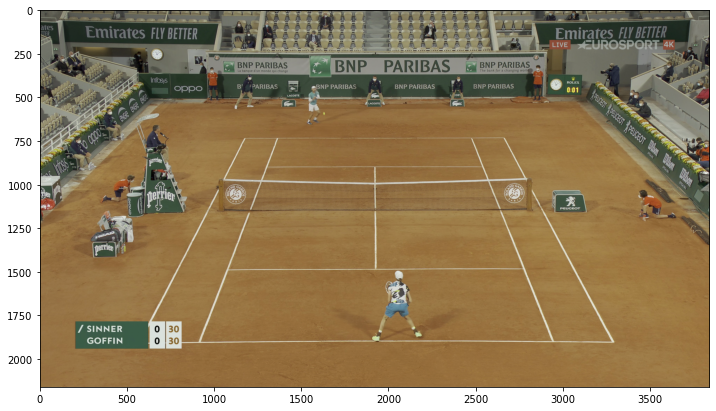

In [25]:
plt.imshow(image)

# Aufgabe

Untersuche den nachfolgenden Cythoncode. Was bremst den Code aus? Wie könnte man diesen verbessern?

In [7]:
%load_ext cython

In [8]:
%%cython -a

def cython_color2gray(image):
    cdef int x,y,z
    cdef double z_val, grey
    for x in range(len(image)):
        for y in range(len(image[x])):
            for z in range(len(image[x][y])):
                if z == 0:
                    grey = image[x][y][0] * 0.21
                elif z == 1:
                    grey += image[x][y][1] * 0.07
                elif z == 2:
                    grey += image[x][y][2] * 0.72
            image[x][y][0] = grey
            image[x][y][1] = grey
            image[x][y][2] = grey
    return image

In [9]:
t1 = %timeit -r 1 -n 1 -o cython_color2gray(image.copy())

1min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Lösung:


- Man sieht oben, dass `image`s Daten als row-major mit Type `np.float32` (in C `float`) gespeichert sind. Daher sollte man ein Memoryview verwenden für effizienten Datenzugriff.
- Wir verwenden den *fused type* `floating`für generischeren Cythoncode.
- `len()` ist eine Pythonfunktion und sollte daher nicht verwendet werden. Da `image` ein `np.array` ist, sollte man stattdessen `image.shape[i]` verwenden um die Anzahl der Elemente in der entsprechenden Dimension zu erhalten.
- Wenn man genau hinschaut, sieht man, dass die innerste Schleife unnötig ist. 
- Die drei Zuweisungen am Ende kann man auch bequemer via Slicing in einer Zeile schreiben.
- Die Indizierung via `image[i,j,k]` ist besser lesbar als `image[i][j][k]`. Macht aber keinen Unterschied bezüglich Laufzeit.
- Wir deaktivieren negative Indizes und Checks der Indizes via Compilerdirectives (Cython).
- Zusätzlich setzen wir für den C Compiler die beiden üblichen Optimierungsflags `-O3` und `-march=native`.

In [21]:
%%cython -a -c=-O3 -c=-march=native
# cython: boundscheck=False, wraparound=False

from cython cimport floating

def cython_color2gray(floating[:, :, ::1] image):
    cdef int x,y,z
    cdef double z_val, grey
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            image[x, y, :] = image[x, y, 0] * 0.21 + image[x, y, 1] * 0.07 + image[x, y, 2] * 0.72
    return image

In [11]:
t2 = %timeit -r 1 -n 1 -o cython_color2gray(image.copy())

218 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
image_gray = cython_color2gray(image.copy())

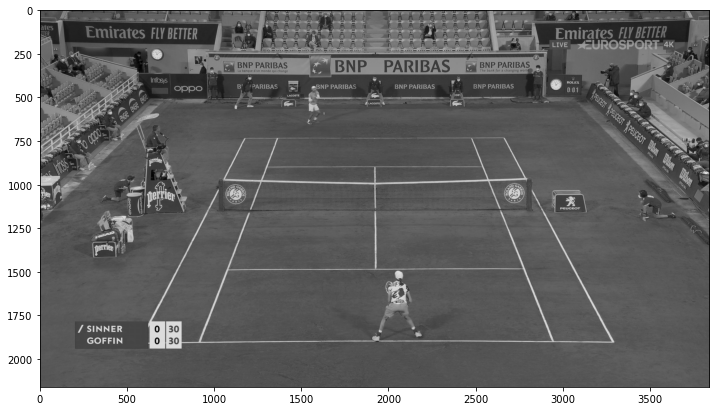

In [26]:
plt.imshow(image_gray)

In [15]:
# Speedup
t1.average / t2.average

319.45528856220096